In [12]:
import torch
import torch.nn as nn
import torch.nn. functional as F
import seaborn as sns
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

print(f"Torch version: {torch.__version__}")

torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Torch version: 2.9.0+cpu
cpu


In [6]:
class Expert(nn.Module):
    """
    A single expert - just a standard Feed-Forward Network (FFN)

    Architecture:
    Input (d_model) → Linear → GELU → Linear → Output (d_model)

    Example: d_model=512, d_ff=2048
    Input: [batch, seq_len, 512]
    Hidden: [batch, seq_len, 2048]
    Output: [batch, seq_len, 512]
    """
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()

        self.w1 = nn.Linear(d_model, d_ff)     # Expand
        self.w2 = nn.Linear(d_ff, d_model)     # Contract
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        Args:
            x: [batch, seq_len, d_model]
        Returns:
            output: [batch, seq_len, d_model]
        """
        # Expand and activate
        hidden = F.gelu(self.w1(x))            # [batch, seq_len, d_ff]
        hidden = self.dropout(hidden)

        # Contract back to d_model
        output = self.w2(hidden)               # [batch, seq_len, d_model]
        output = self.dropout(output)

        return output

# Test it!
d_model = 512
d_ff = 2048
expert = Expert(d_model, d_ff)

# Create dummy input
batch_size = 2
seq_len = 10
x = torch.randn(batch_size, seq_len, d_model)

# Forward pass
output = expert(x)
print(f"Input shape:  {x.shape}")
print(f"Output shape: {output.shape}")
print(f"✓ Expert works! Same shape in and out.")


Input shape:  torch.Size([2, 10, 512])
Output shape: torch.Size([2, 10, 512])
✓ Expert works! Same shape in and out.


In [7]:
class Router(nn.Module):
    """
    Router: Decides which expert handles each token

    How it works:
    1. Token → Linear layer → Scores for each expert
    2. Softmax → Probabilities
    3. Argmax → Pick best expert

    Example with 4 experts:
    Token embedding → Router → [0.1, 0.6, 0.2, 0.1] → Pick Expert 1
    """
    def __init__(self, d_model, num_experts):
        super().__init__()

        # Simple linear layer to produce expert scores
        self.gate = nn.Linear(d_model, num_experts, bias=False)
        self.num_experts = num_experts

    def forward(self, x):
        """
        Args:
            x: [batch, seq_len, d_model] - token embeddings

        Returns:
            expert_indices: [batch, seq_len] - which expert for each token
            expert_probs: [batch, seq_len, num_experts] - probabilities
            router_logits: [batch, seq_len, num_experts] - raw scores
        """
        # Compute scores for each expert
        router_logits = self.gate(x)  # [batch, seq_len, num_experts]

        # Convert to probabilities
        router_probs = F.softmax(router_logits, dim=-1)

        # Pick the best expert for each token (top-1 routing)
        expert_indices = torch.argmax(router_probs, dim=-1)  # [batch, seq_len]

        return expert_indices, router_probs, router_logits


# Test the router!
num_experts = 8
router = Router(d_model, num_experts)

# Same dummy input as before
x = torch.randn(batch_size, seq_len, d_model)

expert_indices, router_probs, router_logits = router(x)

print(f"Input shape: {x.shape}")
print(f"Router logits shape: {router_logits.shape}")
print(f"Router probs shape: {router_probs.shape}")
print(f"Expert indices shape: {expert_indices.shape}")
print(f"\nFirst token routing:")
print(f"  Probabilities: {router_probs[0, 0]}")
print(f"  Chosen expert: {expert_indices[0, 0].item()}")
print(f"  ✓ Router working!")

Input shape: torch.Size([2, 10, 512])
Router logits shape: torch.Size([2, 10, 8])
Router probs shape: torch.Size([2, 10, 8])
Expert indices shape: torch.Size([2, 10])

First token routing:
  Probabilities: tensor([0.0761, 0.0674, 0.1898, 0.1947, 0.0668, 0.1870, 0.1511, 0.0672],
       grad_fn=<SelectBackward0>)
  Chosen expert: 3
  ✓ Router working!


In [8]:
def load_balance_loss(router_probs, expert_indices, num_experts):
    """
    Encourages uniform distribution of tokens across experts

    The math:
    - f_i = fraction of tokens that went to expert i
    - P_i = average router probability for expert i
    - Loss = num_experts × Σ(f_i × P_i)

    Why this works:
    - If all experts get equal load: f_i = P_i = 1/num_experts
    - Loss = num_experts × num_experts × (1/num_experts)² = 1.0 (minimum)
    - If imbalanced: Loss > 1.0

    Args:
        router_probs: [batch, seq_len, num_experts]
        expert_indices: [batch, seq_len]
        num_experts: int

    Returns:
        loss: scalar tensor
    """
    # Flatten to [total_tokens, num_experts] and [total_tokens]
    batch_size, seq_len, _ = router_probs.shape
    total_tokens = batch_size * seq_len

    router_probs_flat = router_probs.view(-1, num_experts)  # [total_tokens, num_experts]
    expert_indices_flat = expert_indices.view(-1)            # [total_tokens]

    # Compute f_i: fraction of tokens assigned to each expert
    f = torch.zeros(num_experts, device=router_probs.device)
    for i in range(num_experts):
        f[i] = (expert_indices_flat == i).float().sum() / total_tokens

    # Compute P_i: mean router probability for each expert
    P = router_probs_flat.mean(dim=0)  # [num_experts]

    # Compute auxiliary loss
    aux_loss = num_experts * torch.sum(f * P)

    return aux_loss, f, P


# Test it!
expert_indices, router_probs, router_logits = router(x)
aux_loss, f, P = load_balance_loss(router_probs, expert_indices, num_experts)

print(f"Load balance loss: {aux_loss.item():.4f}")
print(f"\nExpert utilization (f):")
for i in range(num_experts):
    print(f"  Expert {i}: {f[i].item()*100:.1f}%")
print(f"\nAverage router probabilities (P):")
for i in range(num_experts):
    print(f"  Expert {i}: {P[i].item():.4f}")

Load balance loss: 1.0686

Expert utilization (f):
  Expert 0: 10.0%
  Expert 1: 5.0%
  Expert 2: 10.0%
  Expert 3: 15.0%
  Expert 4: 15.0%
  Expert 5: 30.0%
  Expert 6: 5.0%
  Expert 7: 10.0%

Average router probabilities (P):
  Expert 0: 0.1087
  Expert 1: 0.1083
  Expert 2: 0.1287
  Expert 3: 0.1323
  Expert 4: 0.1395
  Expert 5: 0.1550
  Expert 6: 0.1122
  Expert 7: 0.1153


In [9]:
class SwitchMoELayer(nn.Module):
    """
    Complete Switch Transformer MoE Layer

    Components:
    1. Router - decides expert for each token
    2. Multiple experts - process tokens
    3. Load balancing - keep experts utilized

    Flow:
    Input → Router → Dispatch to experts → Combine → Output
    """
    def __init__(
        self,
        d_model=512,
        d_ff=2048,
        num_experts=8,
        capacity_factor=1.25,
        dropout=0.1
    ):
        super().__init__()

        self.num_experts = num_experts
        self.d_model = d_model

        # Router
        self.router = Router(d_model, num_experts)

        # Experts
        self.experts = nn.ModuleList([
            Expert(d_model, d_ff, dropout) for _ in range(num_experts)
        ])

        # Capacity: max tokens per expert
        self.capacity_factor = capacity_factor

    def forward(self, x, return_aux_loss=True):
        """
        Args:
            x: [batch, seq_len, d_model]
            return_aux_loss: whether to compute load balancing loss

        Returns:
            output: [batch, seq_len, d_model]
            aux_loss: scalar (if return_aux_loss=True)
        """
        batch_size, seq_len, d_model = x.shape

        # 1. Route tokens to experts
        expert_indices, router_probs, router_logits = self.router(x)

        # 2. Flatten for easier processing
        x_flat = x.view(-1, d_model)  # [batch*seq_len, d_model]
        expert_indices_flat = expert_indices.view(-1)  # [batch*seq_len]

        # 3. Initialize output
        output_flat = torch.zeros_like(x_flat)

        # 4. Process tokens through their assigned experts
        for expert_id in range(self.num_experts):
            # Find tokens assigned to this expert
            expert_mask = (expert_indices_flat == expert_id)

            if expert_mask.any():
                # Get tokens for this expert
                expert_input = x_flat[expert_mask]  # [num_tokens_for_expert, d_model]

                # Process through expert
                expert_output = self.experts[expert_id](expert_input)

                # Put back in output
                output_flat[expert_mask] = expert_output

        # 5. Reshape back
        output = output_flat.view(batch_size, seq_len, d_model)

        # 6. Compute auxiliary loss
        if return_aux_loss:
            aux_loss, f, P = load_balance_loss(
                router_probs,
                expert_indices,
                self.num_experts
            )
            return output, aux_loss
        else:
            return output


# Test the complete MoE layer!
moe_layer = SwitchMoELayer(
    d_model=512,
    d_ff=2048,
    num_experts=8,
    dropout=0.1
)

# Input
x = torch.randn(2, 10, 512)

# Forward pass
output, aux_loss = moe_layer(x)

print(f"Input shape:  {x.shape}")
print(f"Output shape: {output.shape}")
print(f"Aux loss:     {aux_loss.item():.4f}")
print(f"\n✓ Complete Switch MoE layer working!")

Input shape:  torch.Size([2, 10, 512])
Output shape: torch.Size([2, 10, 512])
Aux loss:     1.0534

✓ Complete Switch MoE layer working!


In [10]:
class MultiHeadAttention(nn.Module):
    """
    Standard multi-head attention
    (Not the focus today, but needed for complete transformer)
    """
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        batch_size, seq_len, d_model = x.shape

        # Linear projections
        Q = self.w_q(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        K = self.w_k(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        V = self.w_v(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)

        # Attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.d_k ** 0.5)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)

        # Apply attention to values
        out = torch.matmul(attn, V)
        out = out.transpose(1, 2).contiguous().view(batch_size, seq_len, d_model)
        out = self.w_o(out)

        return out


class SwitchTransformerLayer(nn.Module):
    """
    Complete Switch Transformer Layer:
    x → LayerNorm → Attention → Add & Norm → MoE → Add & Norm → output
    """
    def __init__(
        self,
        d_model=512,
        num_heads=8,
        d_ff=2048,
        num_experts=8,
        dropout=0.1
    ):
        super().__init__()

        # Self-attention
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)

        # MoE FFN (replaces standard FFN)
        self.moe = SwitchMoELayer(d_model, d_ff, num_experts, dropout=dropout)

        # Layer norms
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        """
        Args:
            x: [batch, seq_len, d_model]
            mask: optional attention mask

        Returns:
            output: [batch, seq_len, d_model]
            aux_loss: scalar
        """
        # Self-attention block
        residual = x
        x = self.norm1(x)
        attn_out = self.self_attn(x, mask)
        x = residual + self.dropout(attn_out)

        # MoE block
        residual = x
        x = self.norm2(x)
        moe_out, aux_loss = self.moe(x)
        x = residual + self.dropout(moe_out)

        return x, aux_loss


# Test complete transformer layer!
transformer_layer = SwitchTransformerLayer(
    d_model=512,
    num_heads=8,
    d_ff=2048,
    num_experts=8,
    dropout=0.1
)

x = torch.randn(2, 10, 512)
output, aux_loss = transformer_layer(x)

print(f"Input shape:  {x.shape}")
print(f"Output shape: {output.shape}")
print(f"Aux loss:     {aux_loss.item():.4f}")
print(f"\n✓ Complete Switch Transformer layer working!")

Input shape:  torch.Size([2, 10, 512])
Output shape: torch.Size([2, 10, 512])
Aux loss:     1.0375

✓ Complete Switch Transformer layer working!


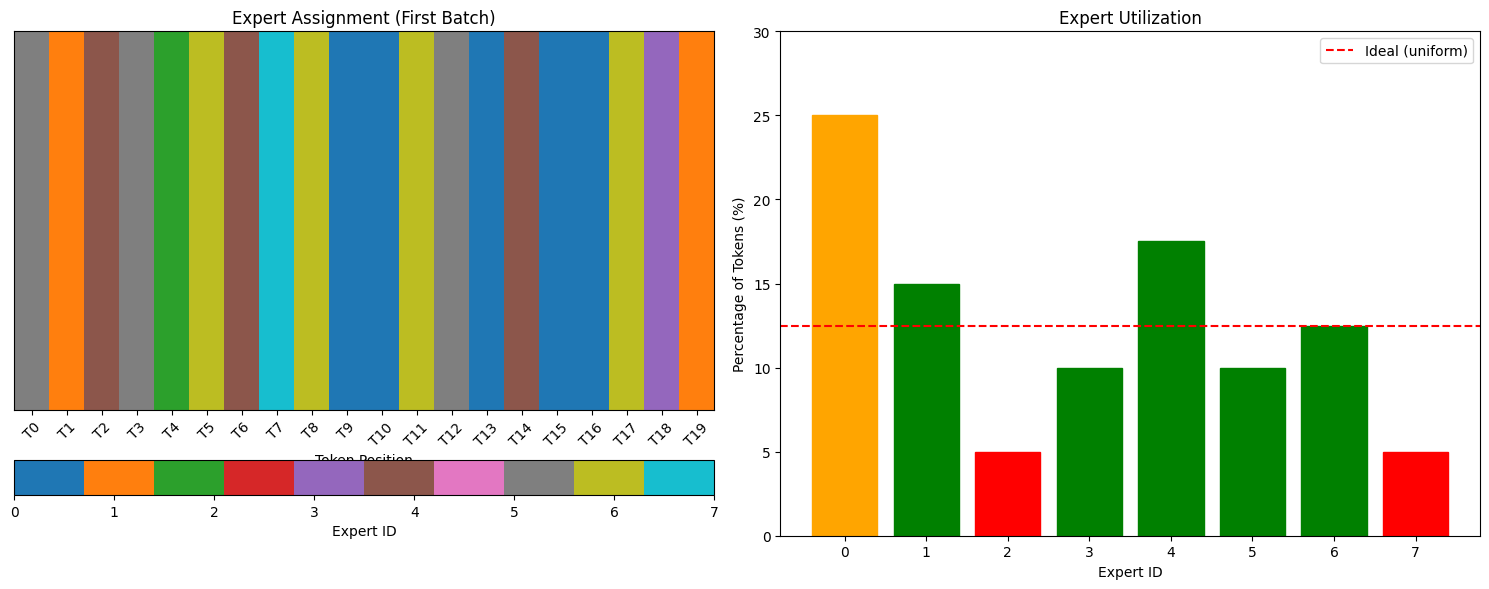


📊 Routing Statistics:
Total tokens: 40
Number of experts: 8
Ideal per expert: 12.5%

Expert 0:  25.0% ( 10 tokens)
Expert 1:  15.0% (  6 tokens)
Expert 2:   5.0% (  2 tokens)
Expert 3:  10.0% (  4 tokens)
Expert 4:  17.5% (  7 tokens)
Expert 5:  10.0% (  4 tokens)
Expert 6:  12.5% (  5 tokens)
Expert 7:   5.0% (  2 tokens)

Utilization variance: 39.0625
(Lower is better, 0 = perfect balance)


In [13]:
def visualize_routing(model, x, token_labels=None):
    """
    Visualize which expert processes which token

    Args:
        model: SwitchMoELayer or SwitchTransformerLayer
        x: input tensor [batch, seq_len, d_model]
        token_labels: optional list of token names
    """
    # Get routing decisions
    if isinstance(model, SwitchTransformerLayer):
        moe_layer = model.moe
    else:
        moe_layer = model

    with torch.no_grad():
        expert_indices, router_probs, _ = moe_layer.router(x)

    batch_size, seq_len = expert_indices.shape
    num_experts = moe_layer.num_experts

    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Plot 1: Expert assignment matrix
    expert_matrix = expert_indices[0].cpu().numpy()  # First batch

    ax = axes[0]
    im = ax.imshow(expert_matrix.reshape(1, -1), cmap='tab10', aspect='auto')
    ax.set_yticks([])
    ax.set_xlabel('Token Position')
    ax.set_title('Expert Assignment (First Batch)')

    if token_labels:
        ax.set_xticks(range(len(token_labels)))
        ax.set_xticklabels(token_labels, rotation=45)

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.1)
    cbar.set_label('Expert ID')

    # Plot 2: Expert utilization bar chart
    ax = axes[1]
    expert_counts = torch.bincount(expert_indices.flatten(), minlength=num_experts)
    expert_percentages = (expert_counts.float() / expert_indices.numel() * 100).cpu().numpy()

    bars = ax.bar(range(num_experts), expert_percentages)
    ax.axhline(y=100/num_experts, color='r', linestyle='--', label='Ideal (uniform)')
    ax.set_xlabel('Expert ID')
    ax.set_ylabel('Percentage of Tokens (%)')
    ax.set_title('Expert Utilization')
    ax.legend()
    ax.set_ylim(0, max(expert_percentages) * 1.2)

    # Color bars by utilization
    for i, (bar, pct) in enumerate(zip(bars, expert_percentages)):
        if pct < 100/num_experts * 0.5:
            bar.set_color('red')  # Underutilized
        elif pct > 100/num_experts * 1.5:
            bar.set_color('orange')  # Overutilized
        else:
            bar.set_color('green')  # Good

    plt.tight_layout()
    plt.show()

    # Print statistics
    print(f"\n📊 Routing Statistics:")
    print(f"Total tokens: {expert_indices.numel()}")
    print(f"Number of experts: {num_experts}")
    print(f"Ideal per expert: {100/num_experts:.1f}%\n")

    for i in range(num_experts):
        print(f"Expert {i}: {expert_percentages[i]:5.1f}% "
              f"({expert_counts[i]:3d} tokens)")

    # Compute variance
    variance = expert_percentages.var()
    print(f"\nUtilization variance: {variance:.4f}")
    print(f"(Lower is better, 0 = perfect balance)")


# Test visualization!
moe_layer = SwitchMoELayer(d_model=512, num_experts=8)
x = torch.randn(2, 20, 512)  # 20 tokens

# Create fake token labels
token_labels = [f"T{i}" for i in range(20)]

visualize_routing(moe_layer, x, token_labels)